In [348]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,auc
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
sns.set()

pd.set_option('display.max_columns', 30)

In [349]:
# Funciones que vamos a usar:

# Funcion que balancea los datos calculando el rate de probabilidad del target (probabilidad de que se acepte el servicio).
# Luego genera un grafico que va a mostrar este rate en funcion de los valores del atributo, tomando en cuenta la cantidad
# de datos para cada punto, y el promedio del rate como una linea:

def grafico_balanceador(columna):
    Dataframe = df[[columna, 'y']]
    Para_graficar = Dataframe.groupby(columna).y.agg(['count', 'mean'])
    grafico = sns.scatterplot(data = Para_graficar, x = columna, y = 'mean', hue = 'count', palette = 'crest')
    grafico.axhline(Dataframe.y.mean(), color = 'r')
    grafico.tick_params(axis='x', rotation=90)
    plt.show
    
# Confusion Matrix :

def Matriz_confusion(model):
    
    xpredict = model.predict(x)

    confusion_matrix(y,xpredict)

    cm = confusion_matrix(y, model.predict(x))

    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

In [350]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [351]:
print('Numero de features: ' + str(df.shape[1]))

Numero de features: 21


In [352]:
# Tipos de datos:

df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

#### Hacemos una conversion de valores categoricos a numericos. Los "Yes" van a pasar a ser 1 y los "No" 0 

In [353]:
df['y'] = df['y'].replace(["yes","no"],[1, 0])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [354]:
# Balance de datos del target 'y':

df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [355]:
# Balance de datos % del target 'y':

a = {'%': [df['y'].value_counts()[1]*100/(df['y'].value_counts()[0] + df['y'].value_counts()[1]),
           df['y'].value_counts()[0]*100/(df['y'].value_counts()[0] + df['y'].value_counts()[1])]}

balance = pd.DataFrame (a, index = ['Yes', 'No'])

balance

,%
Yes,11.265417
No,88.734583


In [356]:
df['y'].value_counts()[1]

4640

In [357]:
# Cantidad de nulos:

df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [358]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


# Análisis Univariado:

Se van a evaluar los atributos que tiene el data set para ver que tipo de distribuciones tiene cada uno, asi como evaluación de outliers:

In [359]:
# Voy a crear una Lista de categorias de edad, para poder hacer una mejor visualización de las distribuciones de edades:

Categoria_Edad = []
for i in range(len(df)):
    if df.loc[i,'age'] < 20:
        Categoria_Edad.append('Menor a 20')
        i =+ 1
    elif df.loc[i,'age'] < 31:
        Categoria_Edad.append('Entre 20 y 30')
        i =+ 1
    elif df.loc[i,'age'] < 36:
        Categoria_Edad.append('Entre 31 y 35')
        i =+ 1
    elif df.loc[i,'age'] < 41:
        Categoria_Edad.append('Entre 36 y 40')
        i =+ 1
    elif df.loc[i,'age'] < 46:
        Categoria_Edad.append('Entre 41 y 45')
        i =+ 1
    elif df.loc[i,'age'] < 51:
        Categoria_Edad.append('Entre 46 y 50')
        i =+ 1
    elif df.loc[i,'age'] < 56:
        Categoria_Edad.append('Entre 51 y 55')
        i =+ 1
    elif df.loc[i,'age'] < 61:
        Categoria_Edad.append('Entre 56 y 60')
        i =+ 1
    elif df.loc[i,'age'] < 71:
        Categoria_Edad.append('Entre 61 y 70')
        i =+ 1
    else:
        Categoria_Edad.append('Mayor a 70')
        i =+ 1
        
# Voy a agregar la lista al DataFrame para poder graficar los datos con seaborn a partir del DataFrame:

DF_Visualizacion = df.copy()
DF_Visualizacion['Categoria_Edad'] = Categoria_Edad
DF_Visualizacion.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,Categoria_Edad
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,Entre 56 y 60
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,Entre 56 y 60
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,Entre 36 y 40
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,Entre 36 y 40
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,Entre 56 y 60


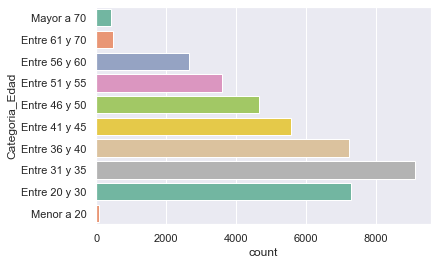

In [360]:
# Voy a ver el conteo de cada variable para entenderlas un poco mejor:

sns.countplot(y = 'Categoria_Edad', data = DF_Visualizacion, palette = 'Set2', order = 
                                                                                    ['Mayor a 70',
                                                                                     'Entre 61 y 70',
                                                                                     'Entre 56 y 60',
                                                                                     'Entre 51 y 55',
                                                                                     'Entre 46 y 50',
                                                                                     'Entre 41 y 45',
                                                                                     'Entre 36 y 40',
                                                                                     'Entre 31 y 35',
                                                                                     'Entre 20 y 30',
                                                                                     'Menor a 20']
             );

Se puede observar que el bulk de personas que recibieron la llamada esta entre 20 y 40 años.

<AxesSubplot:xlabel='count', ylabel='job'>

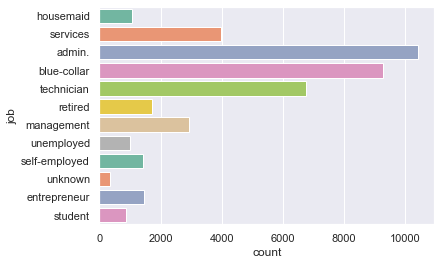

In [361]:
sns.countplot(y = 'job', data = DF_Visualizacion, palette = 'Set2')

Se puede ver que los 3 trabajos mas comunes entre las personas que recibieron la llamada son: Administrativos, técnicos y blue-collar (trabajadores de manualidades).

<AxesSubplot:xlabel='count', ylabel='marital'>

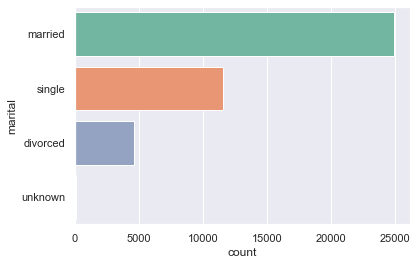

In [362]:
sns.countplot(y = 'marital', data = DF_Visualizacion, palette = 'Set2')

<AxesSubplot:xlabel='count', ylabel='education'>

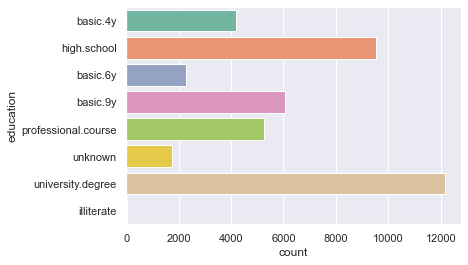

In [363]:
sns.countplot(y = 'education', data = DF_Visualizacion, palette = 'Set2')

<AxesSubplot:xlabel='count', ylabel='housing'>

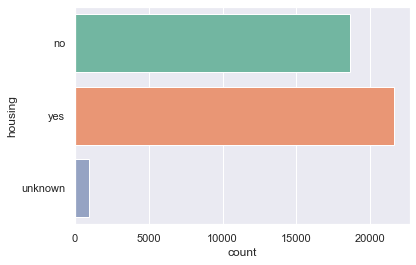

In [364]:
sns.countplot(y = 'housing', data = DF_Visualizacion, palette = 'Set2')

En housing se puede ver un balance bastante parejo entre "yes" y "no". Tambien se ve que hay "unknown". Seria interesante poder investigar si estos son por un error en le data set y si la probabilidad de este valor tiene alguna correlación con otro atributo.

<AxesSubplot:xlabel='count', ylabel='month'>

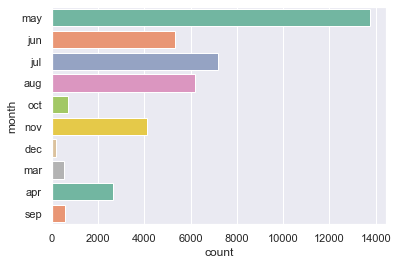

In [365]:
sns.countplot(y = 'month', data = DF_Visualizacion, palette = 'Set2')

Se puede observar que la mayoria de las llamadas se realizaron durante el mes de Mayo. Importante notar que durante Enero y Febrero no se realizaron llamadas. Posiblemente porque pueden ser meses de vacaciones en Brazil, donde la gente no esta en su casa y tampoco se cuenta con tantos vendedores en el banco.

<AxesSubplot:xlabel='count', ylabel='day_of_week'>

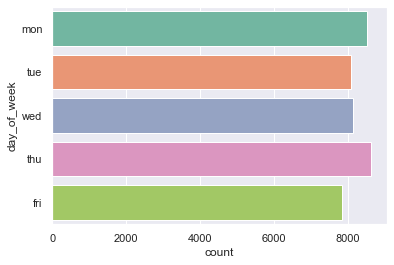

In [366]:
sns.countplot(y = 'day_of_week', data = DF_Visualizacion, palette = 'Set2')

Se ve muy pareja la cantidad de llamados durante la semana.

<AxesSubplot:xlabel='count', ylabel='emp.var.rate'>

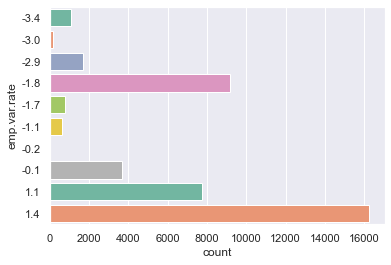

In [367]:
sns.countplot(y = 'emp.var.rate', data = DF_Visualizacion, palette = 'Set2')

emp.var.rate es el employment variation rate. Evalua el cambio en cantidad de empleos de cuarto a cuarto de año. Es interesante ver que en cuartos donde este valor es positivo, es cuando mas llamadas se realizaron.

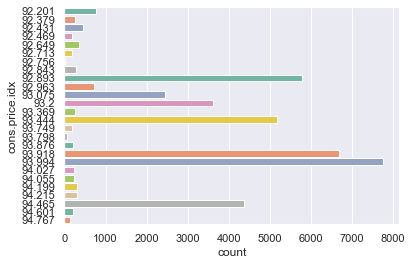

In [368]:
sns.countplot(y = 'cons.price.idx', data = DF_Visualizacion, palette = 'Set2');

cons.price.idx es consumer price index. Es una medida de los precios de bienes durante un dado mes.

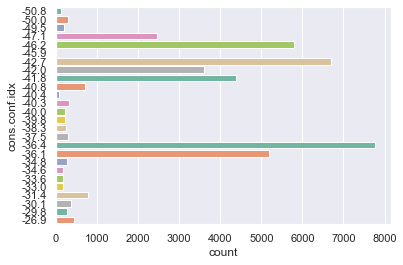

In [369]:
sns.countplot(y = 'cons.conf.idx', data = DF_Visualizacion, palette = 'Set2');

cons.conf.idx es consumer confidence index. Es una medida de cuanto estan gastando los consumidores y tambien se mide mensualmente.

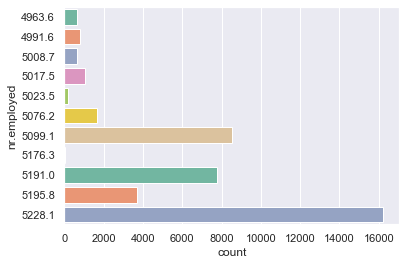

In [370]:
sns.countplot(y = 'nr.employed', data = DF_Visualizacion, palette = 'Set2');

number of employees: Indicador de la cantidad de personas empleadas en el banco al momento de realizar la llamda, tendría que aportar información.
Se ve que se realizaron mas llamadas cuando este valor alcanzo su máximo de 5228.1

<AxesSubplot:xlabel='count', ylabel='y'>

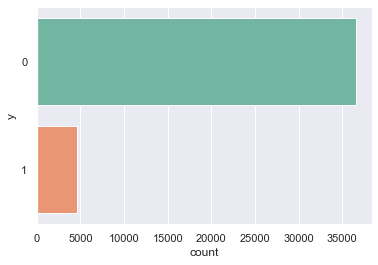

In [371]:
sns.countplot(y = 'y', data = DF_Visualizacion, palette = 'Set2')

Nuevamente vemos el desbalance en el atributo target.

A continuación voy a ver la distribución de algunas de las variables numéricas, para ver si
tienen distribución normal o no:

In [372]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


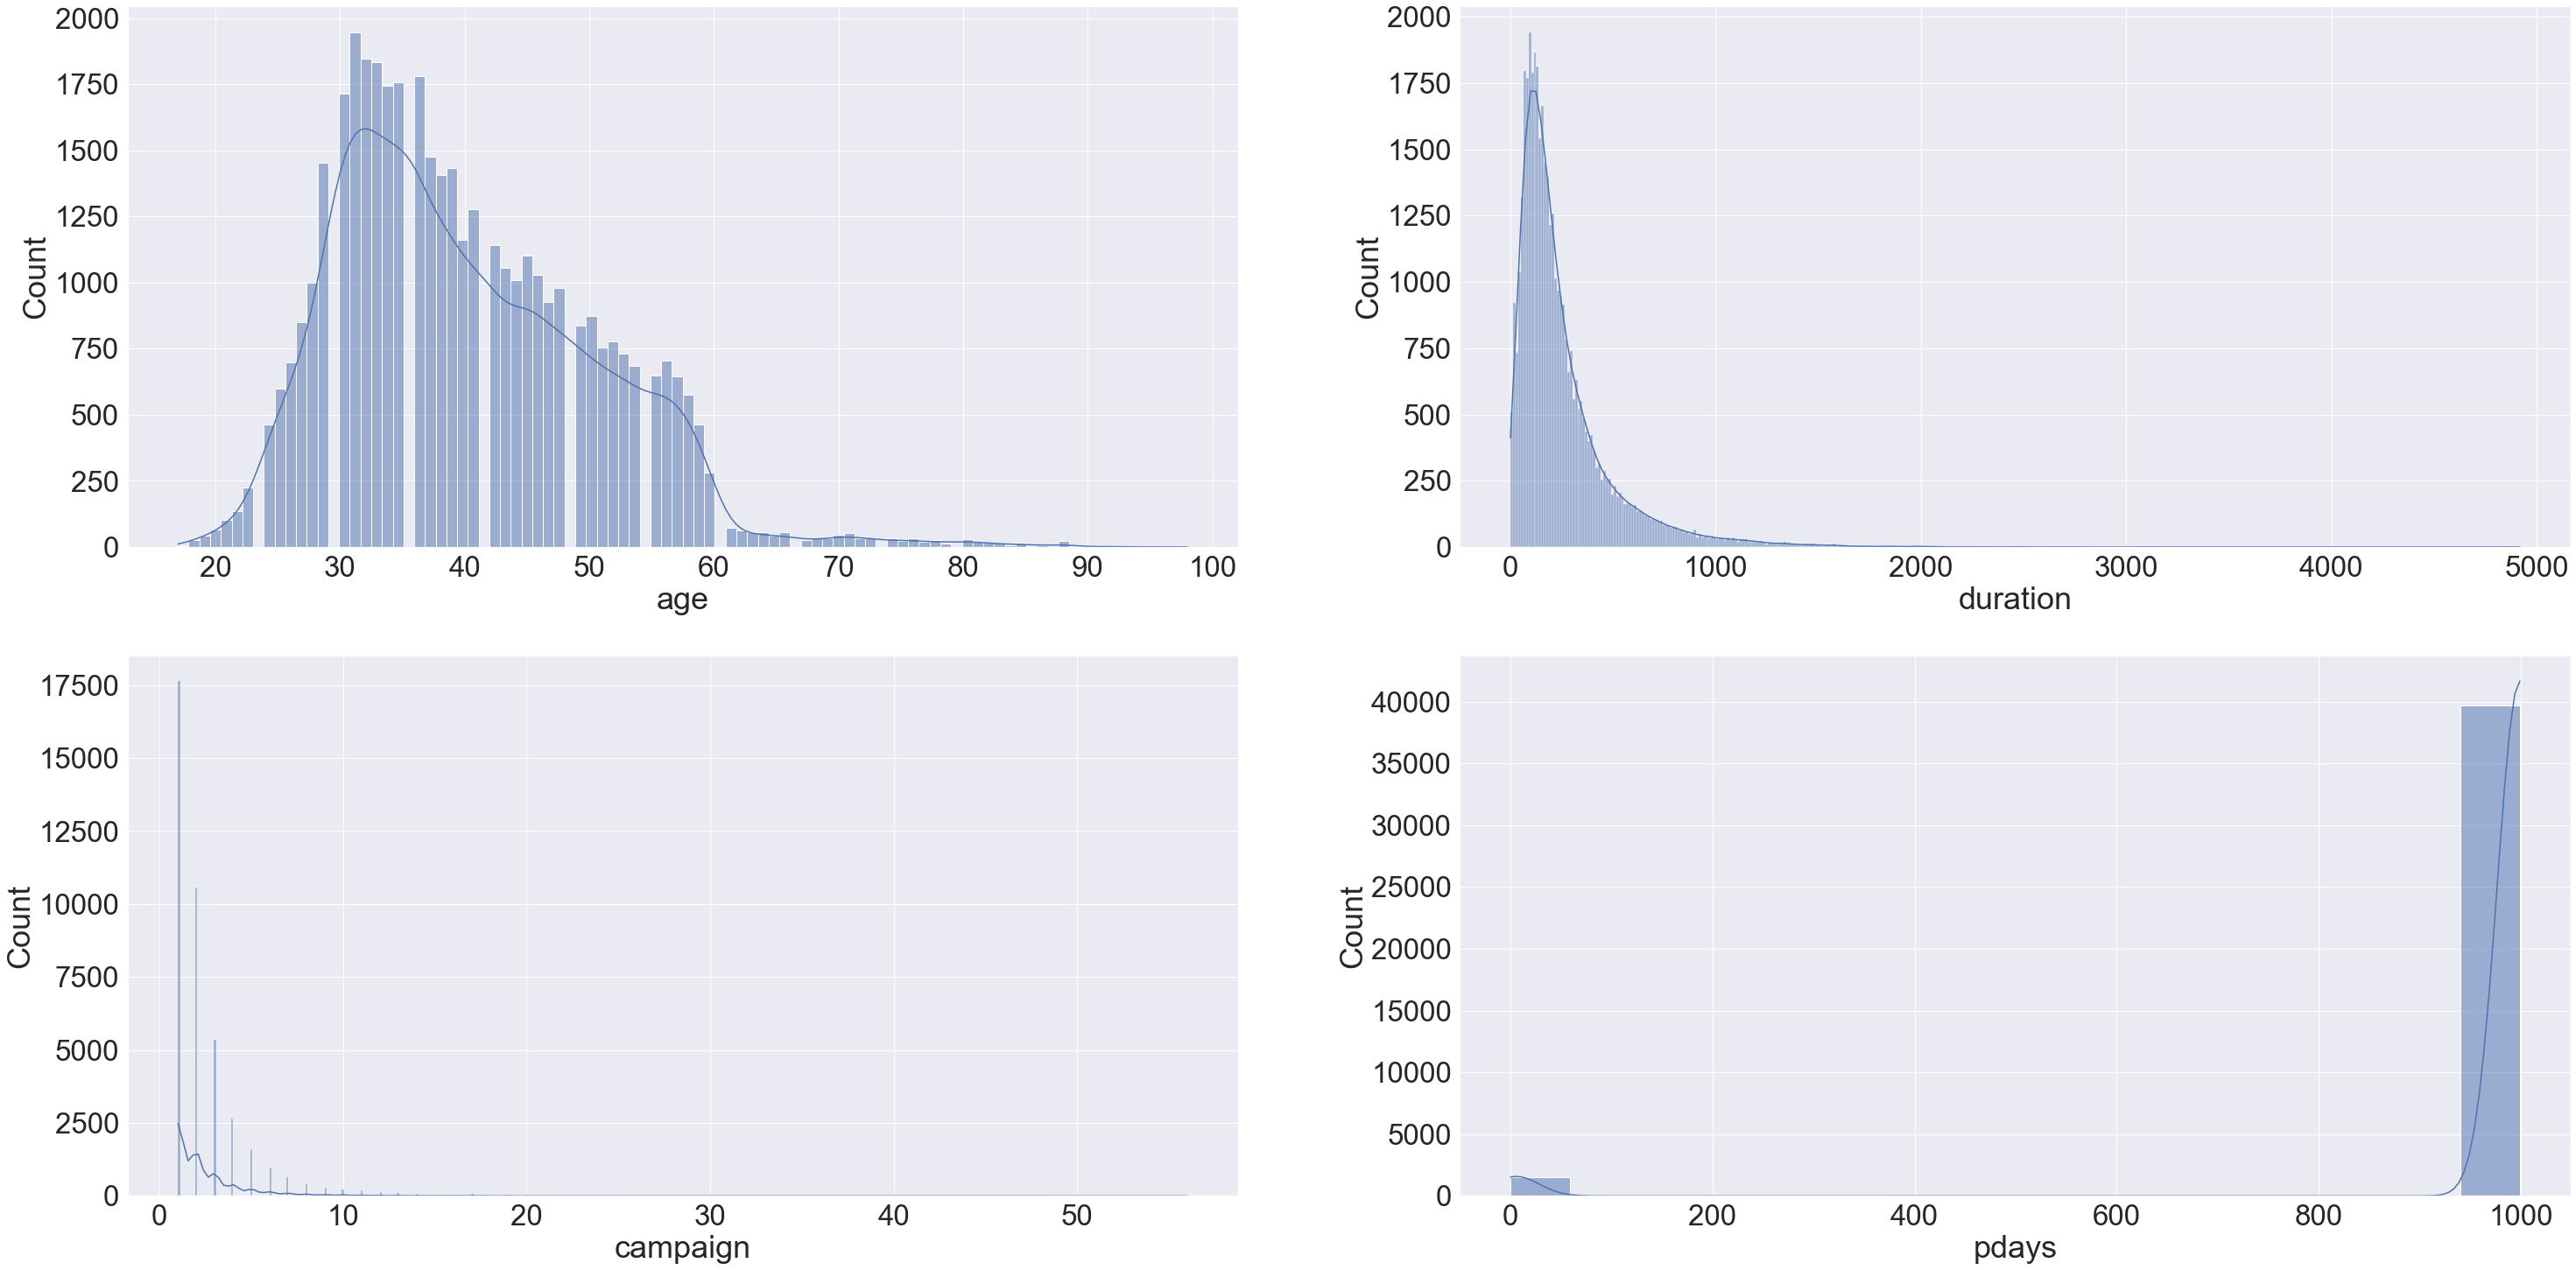

In [373]:
sns.set(font_scale = 3)
figure, axis = plt.subplots(2, 2, figsize = (50,25))
sns.histplot(data = df, x = df['age'], ax=axis[0,0], kde = True)
sns.histplot(data = df, x = df['duration'], ax=axis[0,1], kde = True)
sns.histplot(data = df, x = df['campaign'], ax=axis[1,0], kde = True)
sns.histplot(data = df, x = df['pdays'], ax=axis[1,1], kde = True);

Se puede observar que ninguna distribución parece ser normal. Tanto 'age', 'duration y 'campaign' parecen tener colas a la derecha. Esto es entendible ya que:

- Respecto a age ya vimos que hay una acumulación de valores entre 20 y 40 años.
- Respecto a duration, este valor representa el valor de la duración de la llamada. Sabemos que el atributo 'y' esta muy desbalanceado, mostrando que un 85% de los clientes no toman el plazo fijo. Es razonable pensar que llamadas en las que no se concreta el ofrecimiento, terminen mucho mas rápido que en las que si se acepta.
- Respecto a campaign, vemos que es razonable que haya mayor cantidad de clientes a los que se contacto pocas veces, que clientes que se contactaron varias veces. Esto seguramente se da porque por decision del negocio, a algunos clientes se les deja de insistir y se sigue con otros. Tambien es razonable pensar que si un cliente toma el plazo fijo luego del primer contacto, no se va a continuar llamandolo, por lo que es razonable que exista una cola derecha.

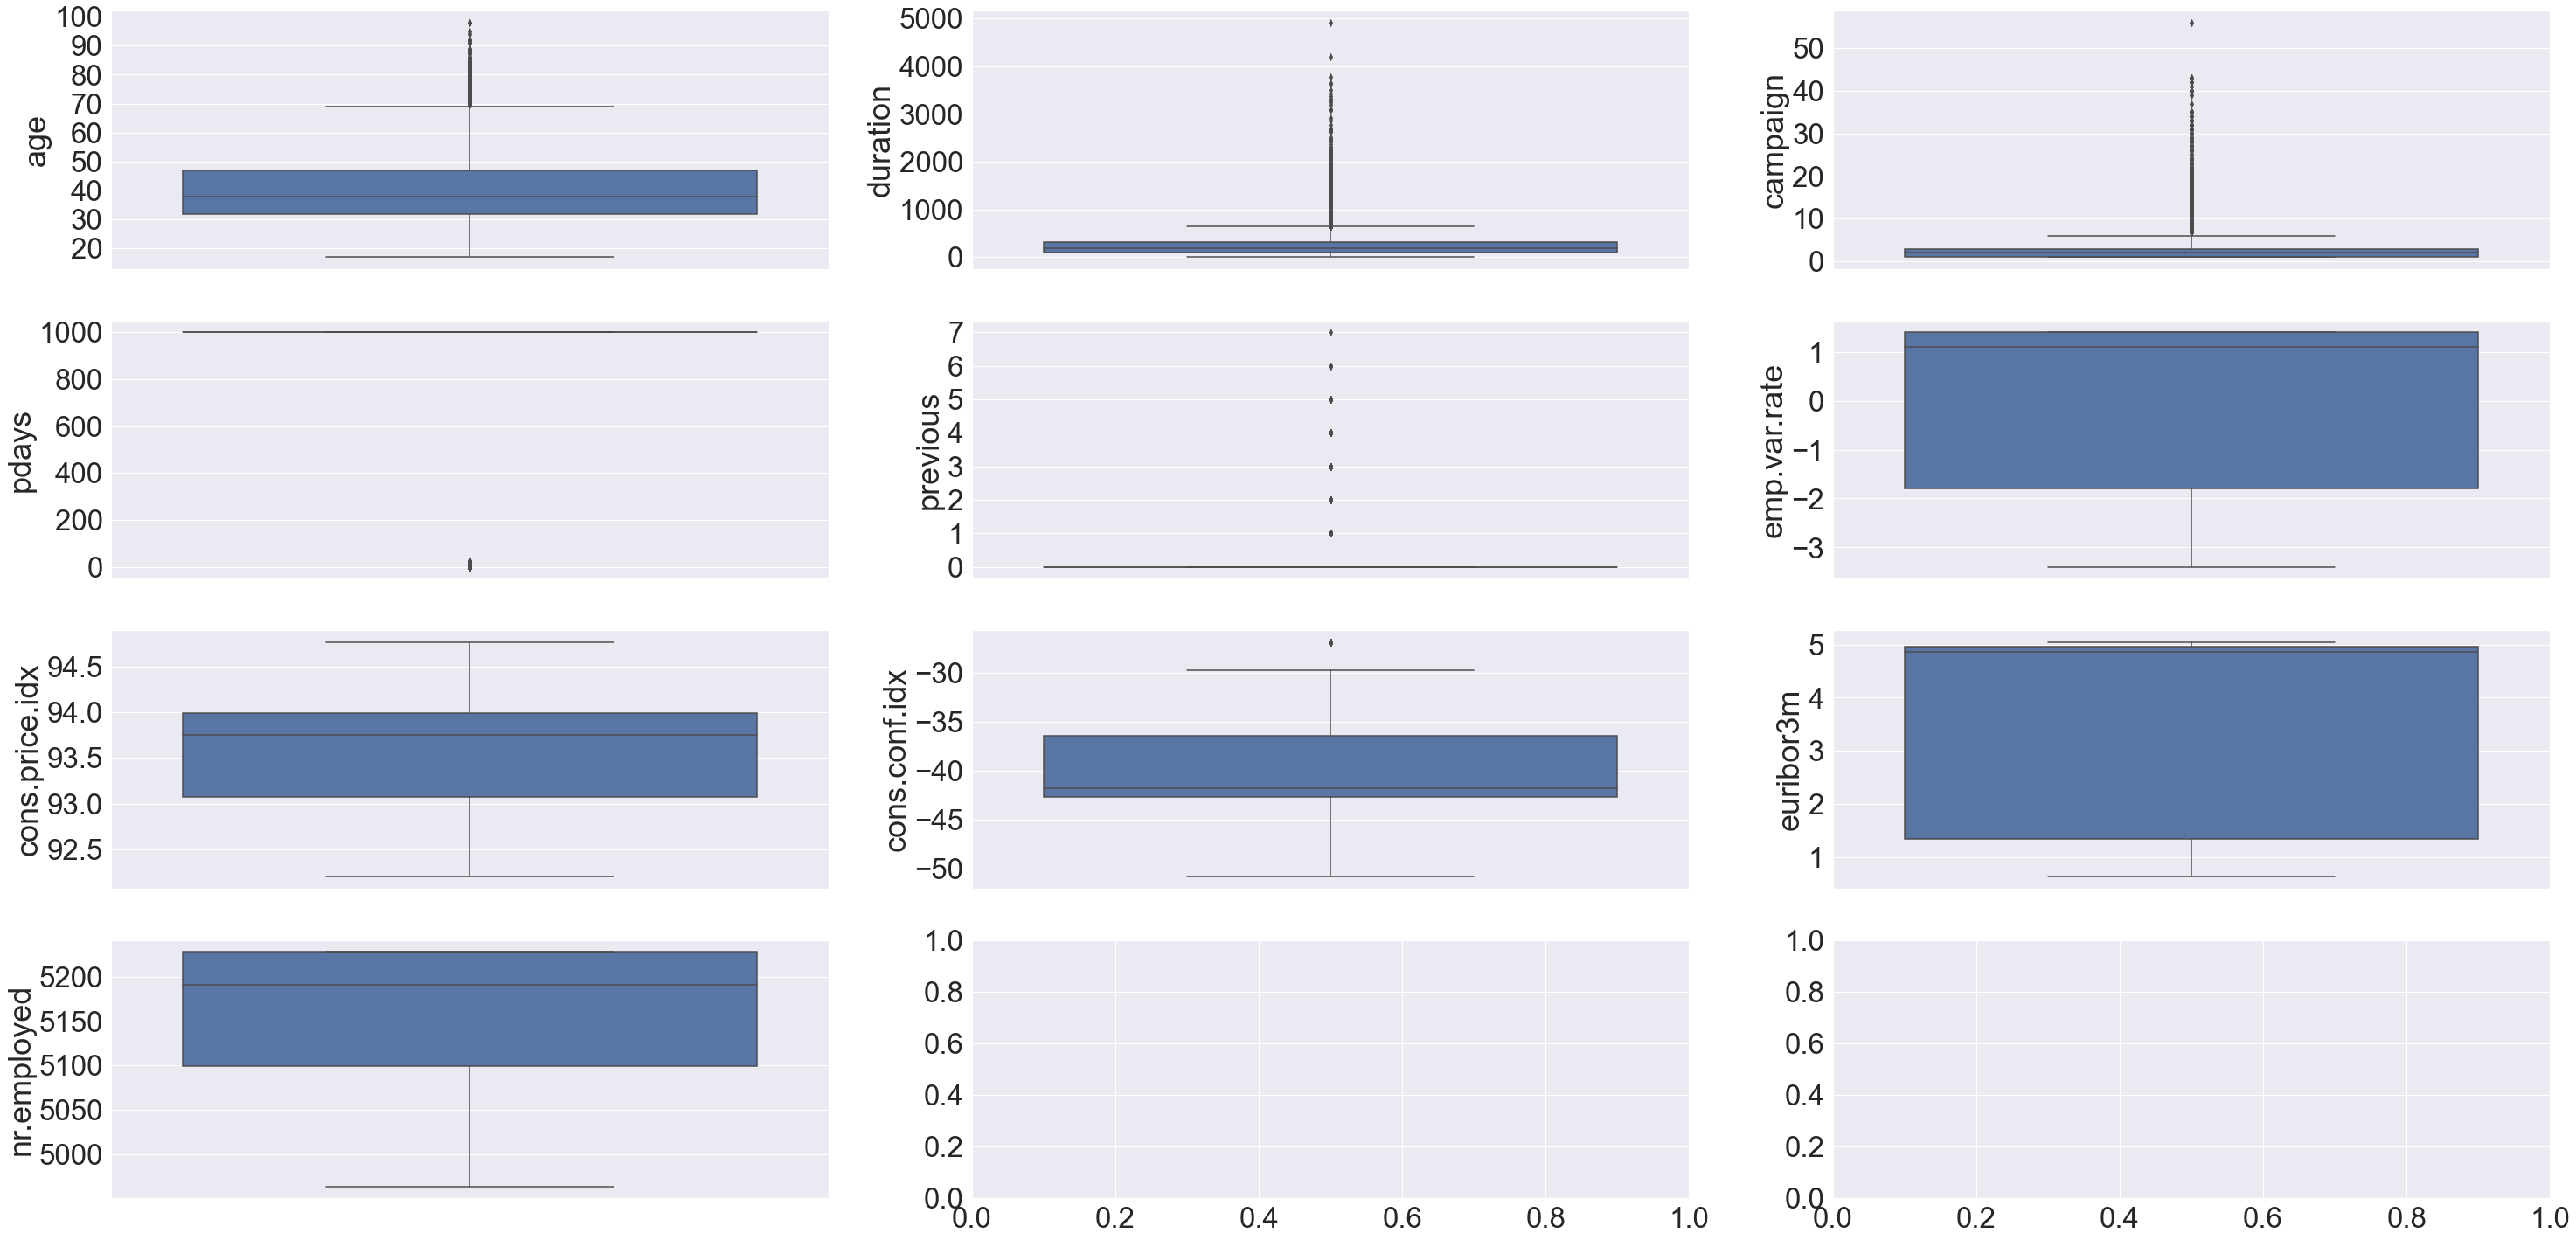

In [374]:
# A continuación vamos a ver algunos boxplots de variables númericas para evaluar presencia de outliers:

sns.set(font_scale = 3)
figure, axis = plt.subplots(4, 3, figsize = (50,25))
sns.boxplot(data = df, y = df['age'], ax=axis[0,0])
sns.boxplot(data = df, y = df['duration'], ax=axis[0,1])
sns.boxplot(data = df, y = df['campaign'], ax=axis[0,2])
sns.boxplot(data = df, y = df['pdays'], ax=axis[1,0])
sns.boxplot(data = df, y = df['previous'], ax=axis[1,1])
sns.boxplot(data = df, y = df['emp.var.rate'], ax=axis[1,2])
sns.boxplot(data = df, y = df['cons.price.idx'], ax=axis[2,0])
sns.boxplot(data = df, y = df['cons.conf.idx'], ax=axis[2,1])
sns.boxplot(data = df, y = df['euribor3m'], ax=axis[2,2])
sns.boxplot(data = df, y = df['nr.employed'], ax=axis[3,0])
sns.set();

Podemos ver que en los boxplot, hay presencia de outliers en age, duration, campaign, pdays, previous y cons.conf.idx. Todos menos pdays tienen outliers posicionados en la parte superior del boxplot. Como vimos anteriormente, la misma explicación podria aplicar a age, duration y campaign. Para previous, se ve que hay muchos casos en 0, por lo que todos los casos diferentes de cero serian outliers.
El caso de pdays hay que investigarlo mas para entender que esta pasando. Segun el diccionario de atributos, el valor 999 corresponde a clientes no contactados anteriormente, por lo que podriamos estar viendo muchos clientes que nunca fueron contactados (por eso el cluster cerca de 1000) y en realidad los valores reales que tenemos que analizar se encuentran abajo.

A continuación vamos a reemplazar los valores 999 de pdays por 0 ya que es el número que mejor representa la cantidad de contactos previos que se tuvieron con el cliente:

In [375]:
df['pdays'] = df['pdays'].replace(999, 0)

<AxesSubplot:ylabel='pdays'>

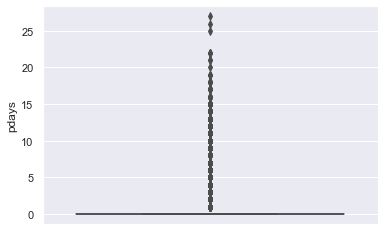

In [376]:
sns.boxplot(data = df, y = df['pdays'])

Tambien Aplicamos CDF (CUMULATIVE DISTRIBUTION FUNCTION):

<ipython-input-377-596b60c1ace0>:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts, bins = np.histogram(df[column], bins=20, normed=True)


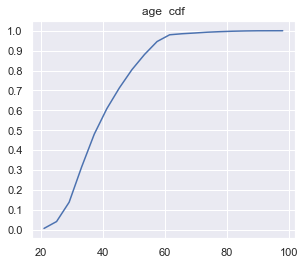

<ipython-input-377-596b60c1ace0>:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts, bins = np.histogram(df[column], bins=20, normed=True)


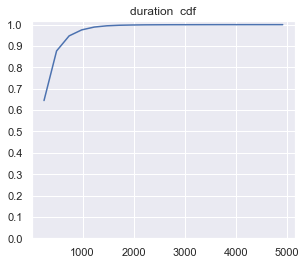

<ipython-input-377-596b60c1ace0>:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts, bins = np.histogram(df[column], bins=20, normed=True)


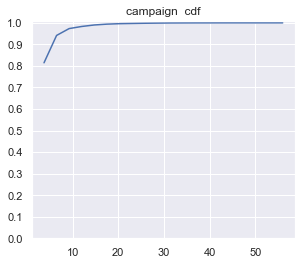

<ipython-input-377-596b60c1ace0>:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts, bins = np.histogram(df[column], bins=20, normed=True)


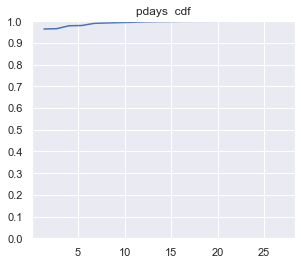

<ipython-input-377-596b60c1ace0>:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts, bins = np.histogram(df[column], bins=20, normed=True)


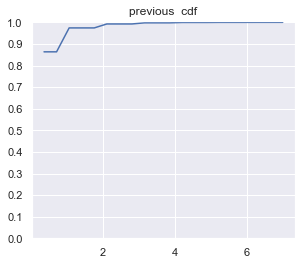

<ipython-input-377-596b60c1ace0>:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts, bins = np.histogram(df[column], bins=20, normed=True)


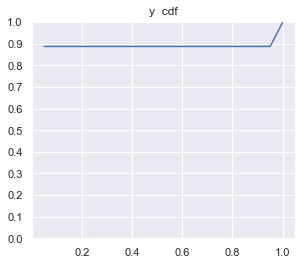

In [377]:
# Generamos una nueva columna con los categorias numericas (solo numeros enteros)

numericas = df.dtypes[df.dtypes == 'int64'].index 

# Vamos a graficar el CDF para nuestras categorias numericas

for column in numericas:
    plt.figure(figsize=(16,4))
    
    plt.subplot(1,3,3)
    counts, bins = np.histogram(df[column], bins=20, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bins[1:], cdf/cdf[-1])
    #plt.xticks(range(15,100,5))
    plt.yticks(np.arange(0,1.1,.1))
    plt.title(f'{column}  cdf')
    plt.show()
    print()

## En base a los resultados podemos observar que : 

* Edad = Los mayores a 60 son outliers
* Campaign = Los mayores a 10 son outliers 
* Duration = Los mayores a 1000 son outliers
* PDays = No tiene sentido mantenerla 

In [378]:
# Eliminamos los outliers de nuestro dataset

df.drop(df[df.age>60].index, inplace=True)  # EDAD

df.drop(df[df.campaign>10].index, inplace=True) # CAMPAÑA

df.drop(df[df.duration>1000].index, inplace=True) # DURACION

print("Nuevo tamaño del data set :", df.shape)

Nuevo tamaño del data set : (38491, 21)


# Análisis Bivariado

Para el análisis bivariado vamos a probar algunas de las relaciones que parecen interesante entender si tienen algun tipo de relación:

- emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m y nr.employed son todos valores numericos relacionados al bienestar economico de los usuarios target, por lo que seria razonable pensar que estan relacionados.
- Ver las relaciones que existen con el target, tomando en cuenta la cantidad de sucesos.

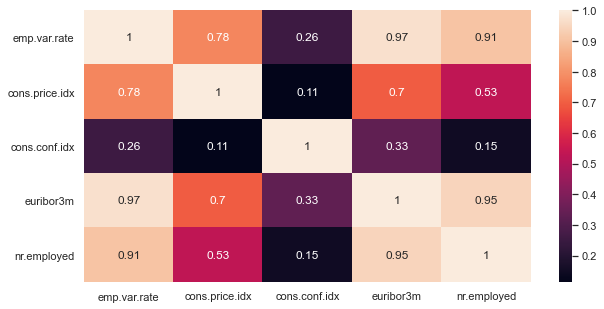

In [379]:
df_numerico = df[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]

plt.figure(figsize=(10,5))
Correlaciones = sns.heatmap(df_numerico.corr(),annot =True)
Correlaciones;

Como se puede ver, existe gran correlación de Pearson entre: emp.var.rate, cons.price.idx, euribor3m y nr.employed. No hay tanta relación con cons.conf.idx.
Se podria pensar que cuando se aplique el modelo, se podria utilizar solo 1 o 2 de estos atributos para no tener tanta multicolinealidad. Tambien se podria utilizar PCA entre estas variables para ver cuantas conviene usar.

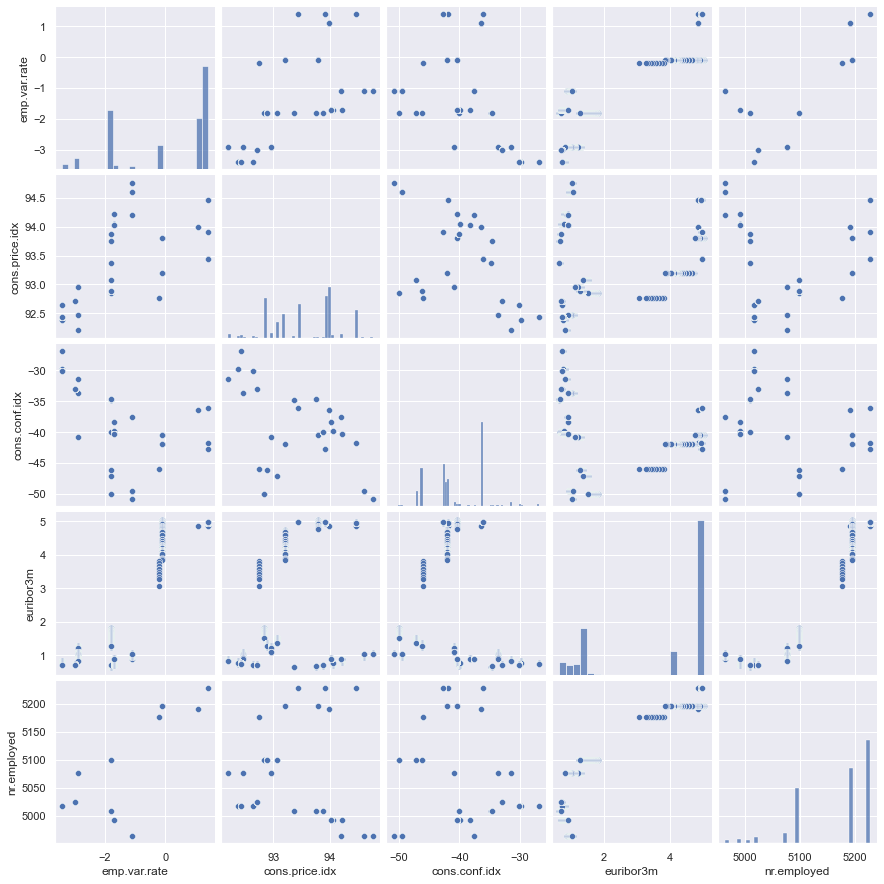

In [380]:
sns.pairplot(df_numerico);

Los pares nr.employed/emp.var.rate, euribor3m/emp.var.rate, cons.price.idx/emp.var.rate y nr.employed/euribor3m parecen tener relaciones lineales asociadas, por lo que podriamos a futuro reemplazar uno para representar a los otros.  

In [381]:
# Vamos a aplicar PCA a estas variables para tratar de entender un poco mejor que poder explicativo tienen y que
# componentes principales podemos encontrar:

# Primero tomamos solo las variables que vamos a utilizar y estandarizar para poder aplicar PCA. Para esto vamos a
# utilizar StandardScaler:
sc = StandardScaler()
df_numericos = sc.fit_transform(df_numerico)

# Luego vamos a aplicar PCA para ver que componentes principales podemos encontrar:

pca = PCA()
df_numericos = pca.fit_transform(df_numericos)

# A continuación vamos a ver que poder explicativo contiene cada uno de los componentes principales en relación a las
# variables originales:

explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.70287235, 0.18971435, 0.10013924, 0.00509619, 0.00217787])

Se puede ver que con solo los 2 principales componentes obtenemos un poder explicativo de varianza de aproximadamente 90%. Esto indicaria que podriamos utilizar estas 2 variables en lugar de todas las contenidas en df_numericos dentro del modelo.
Con esto nos estariamos asegurando:

- Que estamos usando menos variables, disminuyendo la potencia de computo necesaria para el modelo
- Estamos utilizando variables ortogonales entre si. Esto asegura que no existe multicolinealidad entre variables independientes. Esto es una condición para aplicar muchos de los modelos mas comunmente usados.

In [382]:
Componentes_principales = pd.DataFrame(df_numericos, columns = ['PC1','PC2','PC3', 'PC4', 'PC5'])
Componentes_principales.head()

,PC1,PC2,PC3,PC4,PC5
0,-1.32458,0.68416,0.392021,0.012088,0.069523
1,-1.32458,0.68416,0.392021,0.012088,0.069523
2,-1.32458,0.68416,0.392021,0.012088,0.069523
3,-1.32458,0.68416,0.392021,0.012088,0.069523
4,-1.32458,0.68416,0.392021,0.012088,0.069523


In [383]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])
loadings

,PC1,PC2,PC3,PC4,PC5
emp.var.rate,-0.527719,-0.064443,-0.017997,0.802060,-0.271543
cons.price.idx,-0.420044,-0.201308,0.822770,-0.308975,-0.103063
cons.conf.idx,-0.172252,0.968566,0.105188,-0.075274,-0.124415
euribor3m,-0.526640,0.027211,-0.184438,-0.068623,0.826549
nr.employed,-0.487910,-0.128307,-0.526919,-0.500858,-0.465811


Se pueden ver los loadings de cada componente principal (se tomaron los 5 que mas variabilidad pueden explicar).

- PC1 parece tener una combinacion igualitaria de emp.var.rate, cons.price.idx, euribor3m y nr.employed pero con dirección opuesta a estas variables. Es el componente principal que mas variabilidad explica con un 70%.
- PC2 se compone principalmente de cons.conf.idx. Esta variable estaba faltando en PC1 (en comparación con las otras). Con estos 2 componentes principales podemos explicar casi el 90% de la variabilidad de nuestroas datos. Esto tiene sentido entendiendo que PC1 contiene en buena proporcion la informacion de 4 de las 5 variables originales y PC2 contiene principalmente la faltante en PC1.
- PC3 contiene principalmente cons.price.idx y nr.employed. Con esta información llegaria practicamente a un 100% de explicación de varianza junto con PC1 y PC3, abarcando casi en su totalidad toda la información brindada por las variables originales.

# Análisis multivariado

Quiero poder diferenciar cada atributo entre casos en los que se acepto el plazo fijo y casos en los que no. Al estar muy desbalanceado el target, va a ser dificil sacar algun tipo de conclusión de hacer histogramas simplemente separando con hue cada caso, ya que no seran comparables las alturas de las barras. Podria probarse esto luego de utilizar algun método de balanceo. 
Mientras tanto, voy a crear una función que tome cada columna del Dataframe y arme un scatterplot que indique segun cada atributo, como varia el valor de y, siendo y el promedio de casos en los que se acepto el plazo fijo.
Tambien voy a diferenciar con cambios de color el conteo de casos. Tambien voy a agregar una linea roja donde esta el promedio del ratio de casos que se tomo el plazo fijo.
Voy a enfocarme en buscar partes de graficos donde puntos con alto conteo de casos se alejan de la línea roja. Esto podria significar que hay una tendencia interesante para analizar.

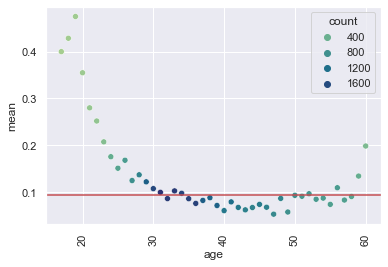

In [384]:
grafico_balanceador('age')

Se puede ver como hay un rango de edades entre 30 y un poco antes de 60 donde la proporción de toma de plazos fijos baja por debajo del promedio. Por edades mayores sube bastante. Esto se puede deber a la poca cantidad de muestras fuera de este rango etario, por lo que no serian tan significativos para analizar.
Si se ve mas en detalle, se puede ver un grupo de personas entre 25 y 30 años que tienen un ratio de toma de plazos fijos ligeramente mayor al promedio, con una densidad de casos intermedia. Esto podria estar mostrando que este grupo de personas tienen mas tendencia a aceptar el trato.

A continuación se va a realizar un test chi2 para evaluar si efectivamente existe relación entre la variable age y el target:

H0 = Age y target son independientes
H1 = Age y target no son independientes, y por lo tanto estan relacionadas

In [385]:
# Hago reshape de age para que pueda entrar bien en el el test de hipotesis

x = df.age.values.reshape(-1,1)
x.shape

(38491, 1)

In [386]:
chi2(x, df.y)

(array([241.86785509]), array([1.53970026e-54]))

Mediante un test chi2, podemos confirmar que las variables age y el target estan relacionadas (aunque no sabemos todavia que tipo de relación tienen) ya que se obtuvo un p-valor muy bajo.

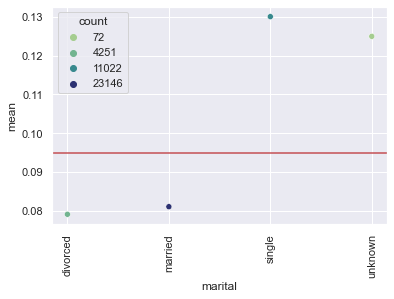

In [387]:
grafico_balanceador('marital')

Con este gráfico podemos ver que la probabilidad de tomar el plazo fijo sube considerablemente si la persona es soltera.

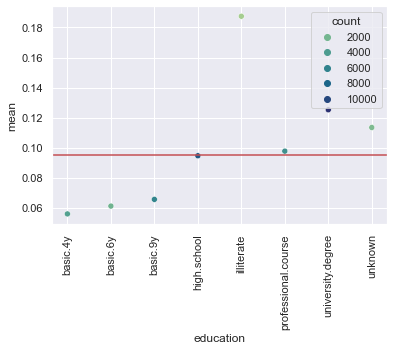

In [388]:
grafico_balanceador('education')

Se puede observar que personas con titulo universitario tienen mas probabilidad de tomar el plazo fijo (con una buena densidad de datos). Personas con nivel de educacion menor tienen menos tendencia. Illiterate por otro lado tiene pocos datos pero parece tener mayor probabilidad.

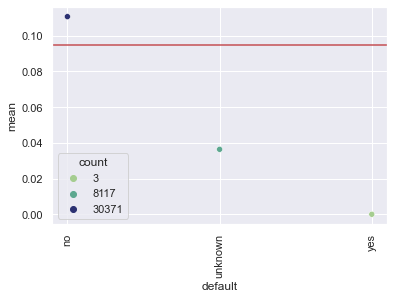

In [389]:
grafico_balanceador('default')

In [390]:
df.default

0             no
1        unknown
2             no
3             no
4             no
          ...   
41181         no
41182         no
41184         no
41185         no
41186         no
Name: default, Length: 38491, dtype: object

Es dificil determinar exactamente si unknown significa que es una persona que no tomo un plazo fijo previamente o si simplemente son valores faltantes en el dataset. Es por esto que no se va a utilizar esta variable en el modelo.

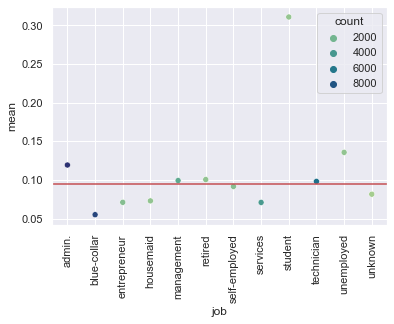

In [391]:
grafico_balanceador('job')

Se nota que las personas que trabajan de "blue-collar" (trabajos manuales) tienen bastante menos probabilidad de tomar el plazo fijo que personas con otros empleos. Estudiantes parecen tener muy altas probabilidades (un poco mas de 30%) pero son pocos datos.

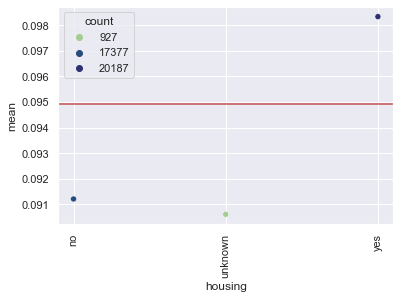

In [392]:
grafico_balanceador('housing')

Las personas que tienen un prestamo para comprar un hogar son ligeramente mas propensas a adquirir el plazo fijo que las que no lo tienen. Es tan pequeña la diferencia que puede ser azar. Es por esto que no se va a utilizar esta variable en el modelo.

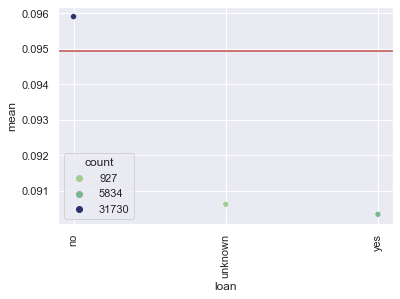

In [393]:
grafico_balanceador('loan')

Se puede ver que no cambia mucho las probabilidades de tomar o no un plazo fijo si se observa si previamente se tomo uno con el banco. No se va a utilizar esta variable para el modelo.

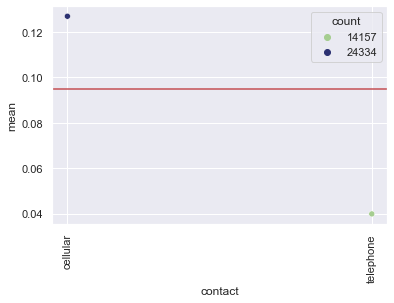

In [394]:
grafico_balanceador('contact')

<ipython-input-395-220d9dc8a77b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['contact'] = DF['contact'].replace('telephone', 0)
<ipython-input-395-220d9dc8a77b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['contact'] = DF['contact'].replace('cellular', 1)


<AxesSubplot:xlabel='age', ylabel='contact'>

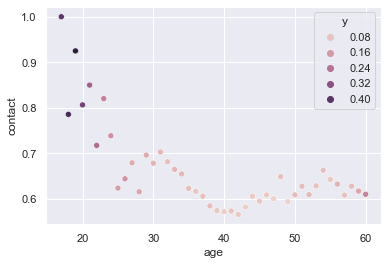

In [395]:
DF = df[['contact', 'age', 'y']]
DF['contact'] = DF['contact'].replace('telephone', 0)
DF['contact'] = DF['contact'].replace('cellular', 1)
Edad_Contacto = DF.groupby('age').agg({'contact':'mean','y':'mean'})
sns.scatterplot(data = Edad_Contacto, x = 'age', y = 'contact', hue = 'y')

Muy interesante ver que las personas que atendieron la llamada por celular tienen muchas mas chances que las que atendieron por telefono de tomar el plazo fijo.
Tambien se realizo un grafico para ver la relación entre edad y el tipo de contacto. Se ve que a edades mas bajas se utiliza mas el celular que el telefono y a edades mas altas baja la proporción. Nuevamente se ve el rango de edades entre 20 y 25 que tiene chances de tomar el plazo fijo altas, y tambien utilizan mucho el celular.

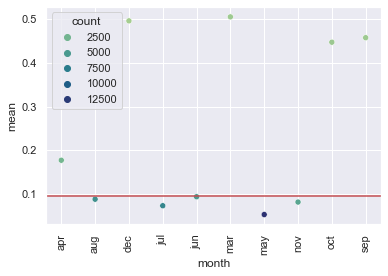

In [396]:
grafico_balanceador('month')

Interesante ver que en el mes de mayo fue cuando mas llamadas se realizaron, pero tambien fue cuando menor ratio de aceptacion del plazo fijo se obtuvo.
Por otro lado, por ejemplo en abril, la aceptación fue practicamente el doble que el promedio y la cantidad de datos no es menor (alrededor de 2500).
Podria ser interesante evaluar junto con la empresa si hay alguna razon validada con conocimiento del negocio de porque se toman mas plazos fijos en abril que en mayo

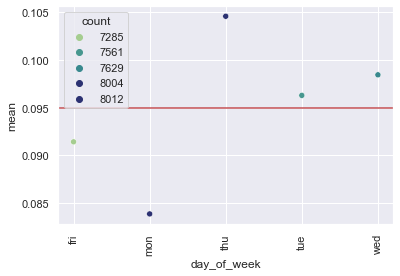

In [397]:
grafico_balanceador('day_of_week')

Pareceria que los Lunes son días especialmente malos para aceptar el plazo fijo, mientras que los Jueves son los mejores, pero la realidad es que no cambia tanto, podria ser azar. No se va a utilizar esta variable para el modelo.

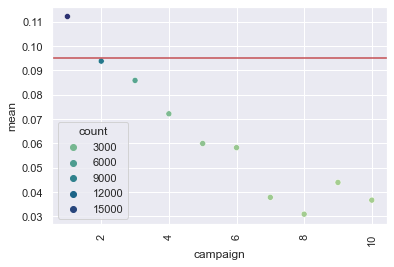

In [398]:
grafico_balanceador('campaign')

Parece que las personas a las que se las contacto menos veces tienen mas chances de tomar el plazo fijo. Podria ser que la gente decide si aceptarlo o no con los primeros intentos y seguir insistiendo no cambia mucho el resultado.

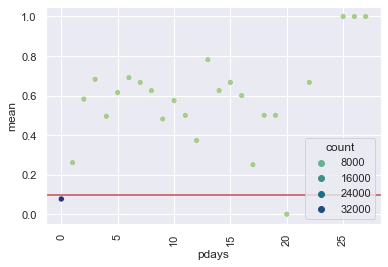

In [399]:
grafico_balanceador('pdays')

Se puede ver que practicamente todos los puntos estan acumulados en el grupo de clientes con los que no se tuvo un contacto previo. No se va a utilizar esta variable para el modelo.

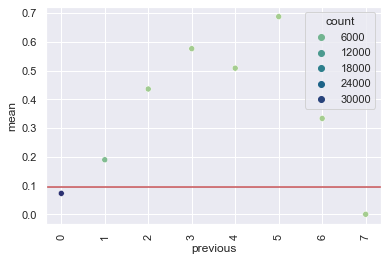

In [400]:
grafico_balanceador('previous')

Este grafico cumple tambien con lo dicho en el de arriba. Tampoco se va a utilizar para el modelo.

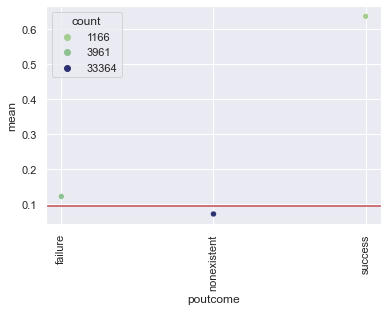

In [401]:
grafico_balanceador('poutcome')

La mayoria de las campañas son nuevas (cerca del promedio), pero para las que no son nuevas, se ve mucha diferencia entre campañas anteriores exitosas y no exitosas. En las exitosas sube muchisimo la probabilidad de tomar el plazo fijo.
Tambien es interesante ver que aunque no sea exitosa, sube la chance de tomar el plazo fijo por arriba del promedio, por lo que simplemente con existir una campaña previa podria aumentarse el ratio.

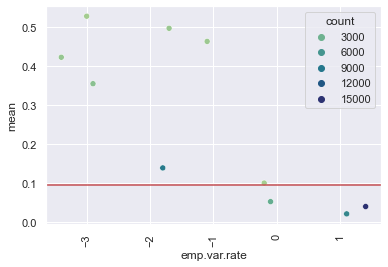

In [402]:
grafico_balanceador('emp.var.rate')

Si evaluamos los casos de mayor densidad de eventos, podemos ver 2 puntos, uno con emp.var.rate negativo y uno positivo. En el negativo se toman mas plazos fijos y en el positivo menos. Al haber menos empleo la gente parece tomar mas plazos fijos, lo cual es parece lógico.

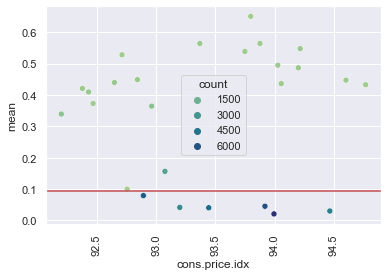

In [403]:
grafico_balanceador('cons.price.idx')

Este valor representa la inflación en Brazil al momento de la llamada (medida cuatrimestralmente). Se ve una tendencia (si se ven los casos con mayores datos) de bajar el ratio de toma de plazo fijo a medidad que la inflación aumenta.

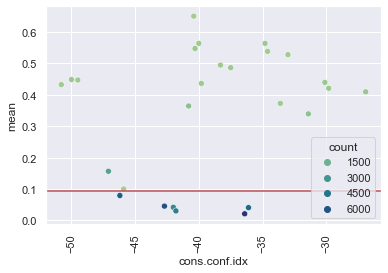

In [404]:
grafico_balanceador('cons.conf.idx')

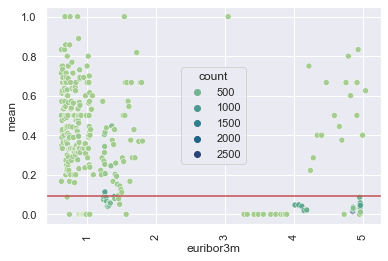

In [405]:
grafico_balanceador('euribor3m')

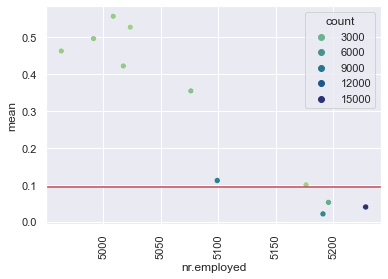

In [406]:
grafico_balanceador('nr.employed')

Este gráfico parece mostrar que mientras mas número de empleados hay, menor es la chance de que la persona tome el plazo fijo. Podria deberse a que mientras mas empleados tiene el banco, mas dinero se gasta en sueldos y por lo tanto la tasa de interes tendra que ser menor.

<function matplotlib.pyplot.show(close=None, block=None)>

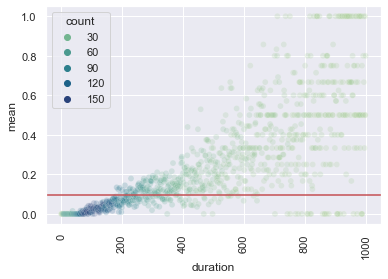

In [407]:
# Utilizando grafico_balanceador estaria obteniendo una imagen poco interpretable por la cantidad de puntos acumulados.
# Por esto tomo directamente el codigo utilizado y le agrego un alpha = 0.2 para que se visualice mejor:

Dataframe = df[['duration', 'y']]
Para_graficar = Dataframe.groupby('duration').y.agg(['count', 'mean'])
grafico = sns.scatterplot(data = Para_graficar, x = 'duration', y = 'mean', hue = 'count', palette = 'crest', alpha = 0.2)
grafico.axhline(Dataframe.y.mean(), color = 'r')
grafico.tick_params(axis='x', rotation=90)
plt.show

Parece haber una relación entre el tiempo que dura la llamada y el target, lo cual como se discutio antes, tiene mucho sentido.

Se va a realizar un test de chi2 para determinar esto.

H0 = Duration y target son independientes H1 = Duration y target no son independientes, y por lo tanto estan relacionadas

In [408]:
x = df.duration.values.reshape(-1,1)
x.shape

(38491, 1)

In [409]:
chi2(x, df.y)

(array([838051.84161135]), array([0.]))

El test no llega a informar ningun número, por lo que se asume que el p-valor es tan bajo que rechazamos H0 a cualquier nivel de significacia.

Es interesante evaluar si hay correlación entre la duración de la llamada y el target desde un punto de vista de exploración de datos y entendimiento del problema del negocio, pero en si esta es una variable que no va a poder ser utilizada por la empresa para realizar ningun tipo de predicción. La duración de una llamada es una dato que solo es conocido luego de que se haya realizado ésta. Tambien si pensamos en la causalidad asociada a estas 2 variables, la duración de la llamada seria la causa de si el cliente acepta o no el plazo fijo y no al reves. Es por esto que no sera una variable que se utilizara para entrenar al modelo.

<ipython-input-410-ec518b290039>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numericos_2['y'] = df['y']


<AxesSubplot:>

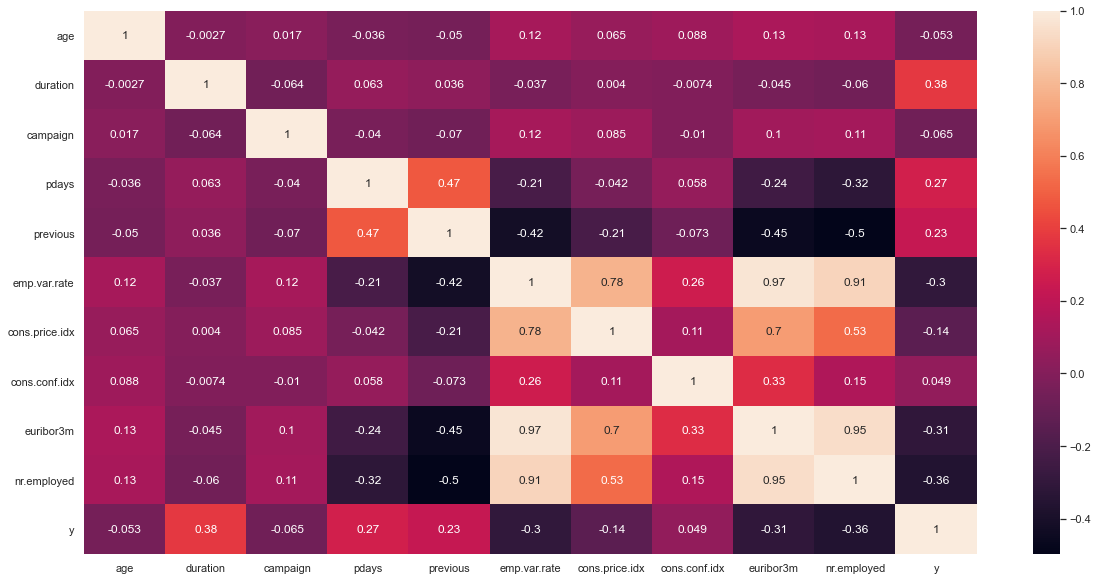

In [410]:
# Por ultimo se va a ver la correlación de Pearson que existe entre las diferentes variables numericas con un heatmap:


df_numericos_2 = df.select_dtypes(exclude=["bool_","object_"])
df_numericos_2['y'] = df['y']

plt.figure(figsize=(20,10))
Correlaciones = sns.heatmap(df_numericos_2.corr(),annot =True)
Correlaciones

Se puede observar que como habiamos dicho, emp.var.rate tiene bastante correlación positiva con otros atributos. Tambien sucede con cons.price.idx, euribor3m y nr.employed.
Fuera de estos atributos, pdays, previous y duration (no se va a usar) parece tener relación.
Cabe aclarar que en lugar de utilizar los 5 indicadores financieros, se van a utilizar los 3 componentes principales calculados anteriormente, que tienen practicamente el mismo poder explicativo.

# Aplicando One Hot Encoding

Se va a utilizar el one hot encoder con las variables categoricas para poder utilizarlas en el modelo como variables numericas. No se utilizara un label encoder ya que este asigna numeros random que no tendrian sentido dentro del modelo.

In [411]:
Data = df[['marital', 'education', 'job', 'contact', 'month', 'poutcome']]

mask = Data.dtypes == np.object
Categorical_cols = Data.columns[mask]

<ipython-input-411-f8289781ae04>:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = Data.dtypes == np.object


In [412]:
DataEncoding = pd.get_dummies(Data)
DataEncoding

,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,job_admin.,job_blue-collar,job_entrepreneur,...,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
41182,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
41184,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
41185,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


Se obtuvieron todas las variables categoricas de interes como variables boleanas. Estas se van a utilizar para entrenar al modelo de clasificación.

# Aplicación de modelos de clasificación

Se va a comenzar aplicando un modelo de clasificación basado en..........
Para medir la performance de los modelos se va a busca que los casos predichos como positivos realmente sean positivos. El sentido de esto es que si lo que se busca es que la empresa disminuya costos de realizar llamadas para vender el plazo fijo, se quiere que las llamadas que se efectuen tengan un ratio de exito grande. Para esto se va a utilizar la precisión como metrica de evaluación (CONFIRMAR ESTO CON EL EQUIPO).

In [413]:
# Primero voy a definir las variables. Para esto se va a combinar age y campaign (variables numericas del dataset,
# original), las variables categoricas transformadas con el one hot encoder y los 3 componentes principales creados,
# haciendo PCA de los indicadores financieros:

Auxiliar_1 = df[['age', 'campaign']]
Auxiliar_PCA = Componentes_principales[['PC1', 'PC2', 'PC3']]

x_aux = Auxiliar_1.join(DataEncoding)
x = Auxiliar_PCA.join(x_aux)
x = x.apply(lambda x: x.fillna(x.median()),axis=0)

y = df['y']


In [414]:
# Separo el data set en training y test. El primero para entrenar al algoritmo y el segundo para evaluar su desempeño.
# El 80% de los datos va a utilizarse en training y el 20% en test.

(x_train,x_test,y_train,y_test) = train_test_split(x,y,test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(30792, 44)
(7699, 44)
(30792,)
(7699,)


In [415]:
# Por ultimo, estandarizamos los datos. Esto lo hacemos para que variables con valores intrinsecamente mas altos
# (componentes principales y age) no ganen mas peso cuando el algoritmo va a realizar la clasificación:

Standard = StandardScaler()
x_train_Std = Standard.fit_transform(x_train)
x_test_Std = Standard.transform(x_test)

# Tambien standarizamos x ya que va a ser el input de la cross validation:

x = Standard.transform(x)

## Seleccion de modelos utilizando cross validation:

Se va a utilizar cross validation para probar entre 5 modelos de clasificación diferentes; KNN, regresion logistica, random  forest, bayes ingenuo y arbol de decisiones.

In [416]:
# KNN:

knnclassifier = KNeighborsClassifier(n_neighbors = 4)
knn_score = cross_val_score(knnclassifier, x, y, cv = 10, scoring = 'precision').mean()

# Regresion logistica: Aumento el numero maximo de iteraciones porque 
# no converge sino:

RegresionLog=LogisticRegression(max_iter=1000)
RL_score = cross_val_score(RegresionLog, x, y, cv = 10, scoring = 'precision').mean()

# Random forest: Se elige como criterio la entropia para maximizar la ganancia de
# informacion por cada nodo en el arbol.
# El numero de estimadores se puede optimizar en proximas iteraciones
# del modelo.

RandomF = RandomForestClassifier(n_estimators = 20, criterion = 'entropy')
RandomF_score = cross_val_score(RandomF, x, y, cv = 10, scoring = 'precision').mean()

# Bayes ingenuo: 

Bayes = GaussianNB()
Bayes_score = cross_val_score(Bayes, x, y, cv = 10, scoring = 'precision').mean()

# Arbol de decision:

ArbolDD = DecisionTreeClassifier()
ArbolDD_score = cross_val_score(ArbolDD, x, y, cv = 10, scoring = 'precision').mean()
             
# Creamos una tabla con todos los scores obtenidos:
             
scores = [['KNN', knn_score], ['Regresion_Logistica', RL_score], ['Random_forest', RandomF_score], 
                       ['Bayes_ingenuo', Bayes_score], ['Arbol de decisiones', ArbolDD_score]]
          
Scores = pd.DataFrame(scores, columns = ['modelo', 'score'])
Scores.set_index('modelo', inplace = True)

Scores

C:\Users\Nico\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nico\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nico\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nico\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is i

,score
modelo,
KNN,0.021043
Regresion_Logistica,0.016811
Random_forest,0.010116
Bayes_ingenuo,0.145590
Arbol de decisiones,0.011193


Por los scores obtenidos se va a seguir con Bayes ingenuo como el modelo elegido

In [417]:
Bayes = GaussianNB()
Bayes.fit(x_train, y_train)

prediccionBayes = Bayes.predict(x_test_Std)
Bayes.score(x_test_Std,y_test)

C:\Users\Nico\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
C:\Users\Nico\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


0.895311079360956

In [418]:
confusion = metrics.confusion_matrix(y_test, prediccionBayes)
pd.DataFrame({'Predecido N': [confusion[0,0], confusion[1,0]], 
              'Predecido P': [confusion[0,1], confusion[1,1]],
              '%': [confusion[0,0]*100/(confusion[0,0]+confusion[0,1]),
                    confusion[1,1]*100/(confusion[1,0]+confusion[1,1])]},
             index=['Realidad N', 'Realidad P'])

,Predecido N,Predecido P,%
Realidad N,6814,123,98.226899
Realidad P,683,79,10.367454


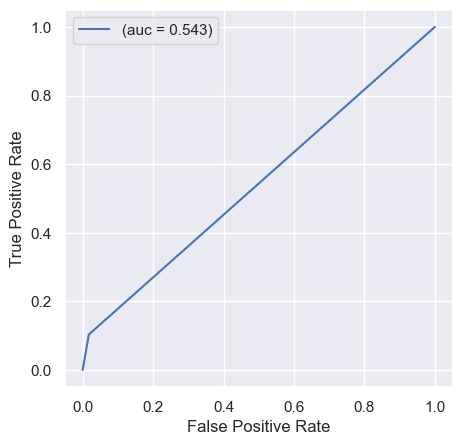

In [419]:
fpr,tpr,threshold =roc_curve(y_test,prediccionBayes)
auc = auc(fpr,tpr)
plt.figure(figsize=(5,5),dpi=100)
plt.plot(fpr,tpr,linestyle='-',label = "(auc = %0.3f)" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [420]:
print('Precisión:' + str(precision_recall_fscore_support(y_test, prediccionBayes, average='macro')[0]))

Precisión:0.6499930005005303


Podemos ver que Bayes ingenuo, aunque fue el mejor modelo de clasificacion (evaluando le precision), solo nos da un 10% de verdaderos positivos (lo que queriamos optimizar) cuando aplicamos una prediccion con los datos de test, lo cual no es optimo.

In [421]:
ros = RandomOverSampler()
ros_x_train, ros_y_train = ros.fit_resample(x_train_Std, y_train)

In [422]:
# Confirmamos que se crearon nuevos datos:

ros_y_train.value_counts()

0    27900
1    27900
Name: y, dtype: int64

In [423]:
# Volvemos a evaluar todos los modelos luego de balancear todo:

x_balanceado, y_balanceado = ros.fit_resample(x, y)

# KNN:

knnclassifier = KNeighborsClassifier(n_neighbors = 4)
knn_score = cross_val_score(knnclassifier, x_balanceado, y_balanceado, cv = 10, scoring = 'precision').mean()

# Regresion logistica: Aumento el numero maximo de iteraciones porque 
# no converge sino:

RegresionLog=LogisticRegression(max_iter=1000)
RL_score = cross_val_score(RegresionLog, x_balanceado, y_balanceado, cv = 10, scoring = 'precision').mean()

# Random forest: Se elige como criterio la entropia para maximizar la ganancia de
# informacion por cada nodo en el arbol.
# El numero de estimadores se puede optimizar en proximas iteraciones
# del modelo.

RandomF = RandomForestClassifier(n_estimators = 20, criterion = 'entropy')
RandomF_score = cross_val_score(RandomF, x_balanceado, y_balanceado, cv = 10, scoring = 'precision').mean()

# Bayes ingenuo: 

Bayes = GaussianNB()
Bayes_score = cross_val_score(Bayes, x_balanceado, y_balanceado, cv = 10, scoring = 'precision').mean()

# Arbol de decision:

ArbolDD = DecisionTreeClassifier()
ArbolDD_score = cross_val_score(ArbolDD, x_balanceado, y_balanceado, cv = 10, scoring = 'precision').mean()
             
# Creamos una tabla con todos los scores obtenidos:
             
scores = [['KNN', knn_score], ['Regresion_Logistica', RL_score], ['Random_forest', RandomF_score], 
                       ['Bayes_ingenuo', Bayes_score], ['Arbol de decisiones', ArbolDD_score]]
          
Scores = pd.DataFrame(scores, columns = ['modelo', 'score'])
Scores.set_index('modelo', inplace = True)

Scores

,score
modelo,
KNN,0.766082
Regresion_Logistica,0.782668
Random_forest,0.671477
Bayes_ingenuo,0.758385
Arbol de decisiones,0.649834


Se puede ver que la performance luego de balancear da considerablemente mejor. Ahora el modelo que mejor performa es la regresion logistica, por lo que se va a continuar con esta como el modelo final a implementar:

In [424]:
RegresionLog=LogisticRegression()
RegresionLog.fit(ros_x_train, ros_y_train)

prediccionRegLog = RegresionLog.predict(x_test_Std)
RegresionLog.score(x_test_Std,y_test)

0.7415248733601767

In [425]:
# Matriz de confusión:

confusionB = metrics.confusion_matrix(y_test, prediccionRegLog)
pd.DataFrame({'Predecido N': [confusionB[0,0], confusionB[1,0]], 
              'Predecido P': [confusionB[0,1], confusionB[1,1]],
              '%': [confusionB[0,0]*100/(confusionB[0,0]+confusionB[0,1]), \
                    confusionB[1,1]*100/(confusionB[1,0]+confusionB[1,1])]},
             index=['Realidad N', 'Realidad P'])

,Predecido N,Predecido P,%
Realidad N,5140,1797,74.095430
Realidad P,193,569,74.671916


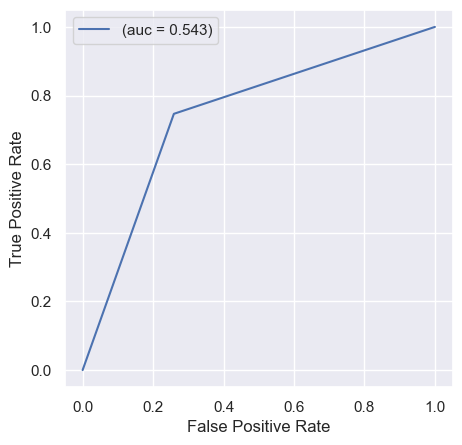

In [426]:
fpr,tpr,threshold =roc_curve(y_test,prediccionRegLog)
plt.figure(figsize=(5,5),dpi=100)
plt.plot(fpr,tpr,linestyle='-',label = "(auc = %0.3f)" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [429]:
print('Precisión:' + str(precision_recall_fscore_support(y_test, prediccionRegLog, average='macro')[0]))

Precisión:0.6021502585458506


Podemos concluir que el modelo utilizado es relativamente efectivo en identificar correctamente casos de compra del plazo fijo.
La precisión total bajo porque la cantidad de casos negativos predichos correctamente bajo respecto al modelo antes de balancear los datos (98% vs 74%). Va a hacer falta continuar optimizando el modelo para identificar si balancearlo fue la dicision correcta o no. Una de las razones por las que bajo la precision podria ser porque al hacer over sampling es mas facil que el modelo termine haciendo overfitting, por lo que en futuras iteraciones del modelo habra que trabajar en eso.